In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import group_data as gd
import flylib
import pylab as plb
calc_new_stats = False
plb.rcParams['pdf.fonttype'] = 42

In [3]:
#import seaborn as sns

## Load the reference frame data and make correlation plots

In [4]:
def kill_spines(top = True,bottom =True, left = True,right=True):
    if top:
        plb.gca().spines['top'].set_visible(False)
        #[x.set_visible(False) for x in plb.gca().get_xticklabels()]
        [x.set_visible(False) for x in plb.gca().get_xticklines()[1::2]]
    if right:
        plb.gca().spines['right'].set_visible(False)
        #[y.set_visible(False) for y in plb.gca().get_yticklabels()]
        [y.set_visible(False) for y in plb.gca().get_yticklines()[1::2]]
    if left:
        plb.gca().spines['left'].set_visible(False)
        [y.set_visible(False) for y in plb.gca().get_yticklabels()]
        [y.set_visible(False) for y in plb.gca().get_yticklines()[::2]]
    if bottom:
        plb.gca().spines['bottom'].set_visible(False)
        [x.set_visible(False) for x in plb.gca().get_xticklabels()]
        [x.set_visible(False) for x in plb.gca().get_xticklines()[::2]]
        
    #plb.gca().set_ybound(-0.1,1.8)
    
    #.set_visible(False)
    
    

In [5]:
import muscle_model as mm
reload(mm)
confocal_model = mm.GeometricModel(filepath = 'model_data.cpkl')
confocal_view = mm.ModelViewMPL(confocal_model)

def warp_fly_image(fly,img,s = 1):
    import cv2
    import cPickle
    pkname = fly.fly_path + '/basis_fits.cpkl'
    fly_frame = mm.Frame();fly_frame.load(pkname)
    A = confocal_model.frame.get_transform(fly_frame)
    Ap = dot([[s,0.0,0],[0,s,0],[0,0,1]],A)
    output_shape = (np.array([1024,1024])*s).astype(int) #confocal shape scale
    output_shape = (output_shape[0],output_shape[1])
    X_warped = cv2.warpAffine(img.T,Ap[:-1,:],output_shape)
    return X_warped

def get_swarm_summary(swarm):
    import cPickle
    corr_list = list()
    norm_list = list()
    freq_list = list()
    for fly in swarm.flies:
        try:
            f = open(fly.fly_path + 'sf_cov_images.cpkl','rb')
            stats = cPickle.load(f)
            f.close()
            corr_list.append([fly,stats['rwing']['corr_img'].reshape(130,174)*stats['rwing']['norm_img'].reshape(130,174)])
            norm_list.append([fly,stats['rwing']['norm_img'].reshape(130,174)])
            freq_list.append([fly,stats['freq']['corr_img'].reshape(130,174)*stats['rwing']['norm_img'].reshape(130,174)])
        except IOError:
            print fly.fly_num
    warped_imgs = list()
    for fly,img in norm_list:
        warped_imgs.append(warp_fly_image(fly,img))
    group_norm = mean(dstack(warped_imgs),axis = 2)
    
    warped_imgs = list()
    for fly,img in corr_list:
        warped_imgs.append(warp_fly_image(fly,img))
    group_corr = mean(dstack(warped_imgs),axis = 2)
        
    warped_imgs = list()
    for fly,img in freq_list:
        warped_imgs.append(warp_fly_image(fly,img))
    group_freq_corr = mean(dstack(warped_imgs),axis = 2)
    
    return(group_norm,group_corr,group_freq_corr)


    
def plot_swarm_corr(swarm,contour_kwargs = None,
                    line_name = None,
                    plot_pans = None,
                    c = 'k',
                    norm_vmin = -1.0,norm_vmax = 1.0,
                    cov_amp_vmin = -1.0,cov_amp_vmax = 1.0,
                    cov_freq_vmin = -1.0,cov_freq_vmax = 1.0,
                    xbounds = None,ybounds = None,cmap = plb.cm.gray):
    line_label = line_name
    plb.axes(plot_pans[0])
    import os
    filelist = os.listdir('./')
    #line_name = line_name.split('_GFP')[0].split('GMR')[1]
    #antibody_file = filter(lambda x: (line_name in x) and ('(RGB)' in x),filelist)[0]
    #print antibody_file
    #import tifffile
    #tfile = tifffile.TiffFile(antibody_file)
    #antibody_image = tfile.asarray()
    #imshow(antibody_image)
    line_model = confocal_model.get_masks_by_line(confocal_model.frame,(1024,1024),line_name = line_label)[0]
    line_model = line_model.reshape(-1,1024,1024)
    plb.imshow(np.sum(line_model,axis = 0).T,cmap = plb.cm.gray)
    gca().set_xticklabels([])
    gca().set_yticklabels([])
    gca().set_title(line_label,color = c)
    kill_spines()
    gca().set_xbound(xbounds)
    gca().set_ybound(ybounds)
    
    group_norm,group_corr,group_freq_corr = get_swarm_summary(swarm)

    axes(plot_pans[1])
    if norm_vmin is None:
        vman = np.nanmean(group_norm.ravel()) + np.nanstd(group_norm.ravel())*1
        vmin = 0

    imshow(group_norm,cmap = cmap,vmin = vmin,vmax = vmax)
    #subplot(1,2,1)
    #plot_args = {'plot_frame':False,'contour_kwargs':{'edgecolor':'y','alpha':0.5,'facecolor':'none'}}
    plot_args = {'draw_frame':False,'contour_kwargs':contour_kwargs}
    #confocal_view.plot(confocal_model.frame,**plot_args)
    #gca().set_xbound(0,1000)
    #gca().set_ybound(0,1000)
    gca().set_xbound(xbounds)
    gca().set_ybound(ybounds)
    kill_spines()
    #gca().set_title('std image')
    
    #subplot(1,2,2)
    axes(plot_pans[2])
    if cov_amp_vmin is None:
        #vman = np.nanmean(group_corr.ravel()) + np.nanstd(group_corr.ravel())*4
        #vmin = np.nanmean(group_corr.ravel()) - np.nanstd(group_corr.ravel())*4
        vman = 0 + np.nanstd(group_corr.ravel())*4
        vmin = 0 - np.nanstd(group_corr.ravel())*4
    
    imshow(group_corr,cmap = cmap,vmin = vmin,vmax = vmax)
    #print np.min(mean(dstack(warped_imgs),axis = 2))
    #plot_args = {'draw_frame':False,'contour_kwargs':contour_kwargs}
    #confocal_view.plot(confocal_model.frame,**plot_args)
    #gca().set_xbound(0,1000)
    #gca().set_ybound(0,1000)
    gca().set_xticklabels([])
    gca().set_yticklabels([])
    gca().set_xbound(xbounds)
    gca().set_ybound(ybounds)
    kill_spines()
    
    axes(plot_pans[3])
    if cov_freq_vmin is None:
        vman = np.nanmean(group_freq_corr.ravel()) + np.nanstd(group_freq_corr.ravel())*4
        vmin = np.nanmean(group_freq_corr.ravel()) - np.nanstd(group_freq_corr.ravel())*4
        
    imshow(group_freq_corr,cmap = cmap,vmin = vmin,vmax = vmax)
    #print np.min(mean(dstack(warped_imgs),axis = 2))
    #plot_args = {'draw_frame':False,'contour_kwargs':contour_kwargs}
    #confocal_view.plot(confocal_model.frame,**plot_args)
    #gca().set_xbound(0,1000)
    #gca().set_ybound(0,1000)
    gca().set_xticklabels([])
    gca().set_yticklabels([])
    gca().set_xbound(xbounds)
    gca().set_ybound(ybounds)
    kill_spines()
    #gca().set_title('correlation image')
    
    #suptitle(line_name)
    
def get_kwargs(line_name):
    import cPickle
    f = open('../../../mn_expression_matrix_plot/line_database.cpkl','rb')
    line_database = cPickle.load(f)
    f.close()
    contour_kwargs = dict()
    line_name = line_name.split('_GFP')[0].split('GMR')[1]
    for key in line_database[line_name].keys():
        if 'DVM' in key:
            contour_kwargs['DVM1'] = {'linewidth':line_database[line_name]['DVM']/2.0,
                               'edgecolor':'orange','facecolor':'none','alpha':0.6}
            contour_kwargs['DVM2'] = {'linewidth':line_database[line_name]['DVM']/2.0,
                               'edgecolor':'orange','facecolor':'none','alpha':0.6}
            contour_kwargs['DVM3'] = {'linewidth':line_database[line_name]['DVM']/2.0,
                               'edgecolor':'orange','facecolor':'none','alpha':0.6}
        else:
            contour_kwargs[key] = {'linewidth':line_database[line_name][key]/2.0,
                               'edgecolor':'orange','facecolor':'none','alpha':0.6}
    return contour_kwargs

In [6]:
gmrlinenames = ['GMR22H05',
                'GMR10A12',
                'GMR74F03',
                'GMR75B06',
                'GMR29E05',
                'GMR31E10',
                'GMR39E01']

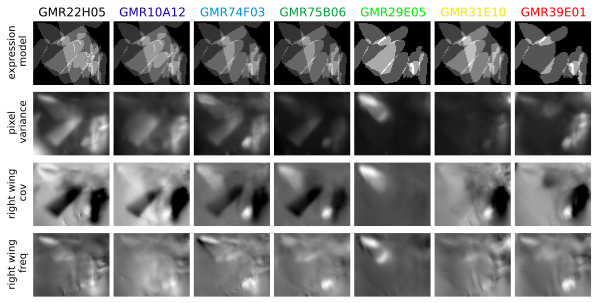

In [7]:
from matplotlib import gridspec
vmin = None#-20.5
vmax = None#20.5
xmin = 60
xmax = 750
xbounds = (xmin,xmax)
ymin = 325
ymax = 900
ybounds = (ymin,ymax)
fig = plb.figure(figsize = (10,5))

cmap = plb.cm.spectral
cmax = len(gmrlinenames)


#gmrlines = gd.exp_swarms#['GMR22H05','GMR74F03','GMR75B06','GMR29E05','GMR31E10','GMR39E01']
gs = gridspec.GridSpec(4,len(gmrlinenames))
for i,line_name in enumerate(gmrlinenames):
    plot_pans = [subplot(gs[row,i]) for row in range(4)]
    if i == 0:
        axes(plot_pans[0])
        gca().set_ylabel('expression\n model')
        axes(plot_pans[1])
        gca().set_ylabel('pixel\n variance')
        axes(plot_pans[2])
        gca().set_ylabel('right wing\n cov')
        axes(plot_pans[3])
        gca().set_ylabel('right wing\n freq')
        
        
    contour_kwargs = get_kwargs(line_name = line_name)
    c = cmap(float(i)/cmax)
    plot_swarm_corr(gd.swarms[line_name],
                    contour_kwargs,
                    line_name = line_name,
                    plot_pans = plot_pans,
                    norm_vmin = None,norm_vmax = None,
                    cov_amp_vmin = None,cov_amp_vmax = None,
                    cov_freq_vmin = None,cov_freq_vmax = None,
                    xbounds = xbounds,ybounds = ybounds,
                    cmap = cm.gray,
                    c = c)
    #savefig(line_name + '_corr' + '.pdf')
    #close()
plt.subplots_adjust(hspace = .05)
plt.subplots_adjust(wspace = .05)
savefig('correlation_images.pdf')

In [8]:
gmrlines = [gd.exp_swarms[key] for key in ['GMR22H05',
                                           'GMR10A12',
                                           'GMR74F03',
                                           'GMR75B06',
                                           'GMR29E05',
                                           'GMR31E10',
                                           'GMR39E01']]

ctrllines = [gd.ctrl_swarms[key + '_GFP'] for key in ['GMR22H05',
                                           'GMR10A12',
                                           'GMR74F03',
                                           'GMR75B06',
                                           'GMR29E05',
                                           'GMR31E10',
                                           'GMR39E01']]

def make_stats_summary(variable = 'amp'):
    fig = plb.figure(figsize = (11,3))
    muscle_list = ['b1','b2','b3','i1','i2','iii1','iii24','iii3','hg1','hg2','hg3','hg4','tpd','tpv','ttm']
    cmap = plb.cm.spectral

    from matplotlib import gridspec
    gs = GridSpec(1,len(muscle_list))
    pans = [plb.subplot(gs[0,i],sharey = plb.gca(),sharex = plb.gca()) for i,m in enumerate(muscle_list)]
    cmax = len(gd.exp_swarms.values())

    for cidx,swarm in enumerate(gmrlines):
        #plb.subplot(7,1,cidx+1,sharey = plb.gca(),sharex = plb.gca())
        cval = float(cidx)/cmax
        offset = cidx*10000
        for fly in swarm.flies:
            try:
                pkldata = fly.get_pkl_data('nnls_fits_no_bk_dF_F_corr_data.cpkl')
                statdata = pkldata[variable]
                zero_idx = argwhere(pkldata['times']>0)[0]
                for i,mkey in enumerate(muscle_list):
                    plb.axes(pans[i])
                    try:
                        plb.plot((cval*1.8),statdata[mkey][zero_idx][0],
                                 'o',color = cmap(cval), alpha = 0.5,ms = 3.0,
                                 markeredgecolor  = 'none')
                        #plb.plot((i*2)+2,pkldata[mkey][zero_idx][0]+offset,
                        #         'o',color = plb.cm.jet(cval), alpha = 0.2,ms = 5.0,markeredgecolor  = 'none')
                    except KeyError:
                        pass#print mkey
                #kill_spines()
            except IOError:
                print 'file missing'

    for cidx,swarm in enumerate(ctrllines):
        #plb.subplot(7,1,cidx+1,sharey = plb.gca(),sharex = plb.gca())
        cval = float(cidx)/cmax
        offset = cidx*10000
        for fly in swarm.flies:
            try:
                pkldata = fly.get_pkl_data('nnls_fits_no_bk_dF_F_corr_data.cpkl')
                statdata = pkldata[variable]
                for i,mkey in enumerate(muscle_list):
                    plb.axes(pans[i])
                    try:
                        c = cmap(cval)
                        c = (c[0],c[1],c[2],0.6)
                        plb.plot((cval*1.8),statdata[mkey][zero_idx][0],
                                 'o',color = cmap(cval),ms = 3.0,
                                 markeredgecolor = c,markerfacecolor = 'w')
                        #plb.plot((i*2)+2,pkldata[mkey][zero_idx][0]+offset,
                        #         'o',color = plb.cm.jet(cval), alpha = 0.2,ms = 5.0,markeredgecolor  = 'none')
                    except KeyError:
                        pass#print mkey
                kill_spines()
            except IOError:
                pass#print 'file missing'
    for i,pan in enumerate(pans):
        plb.axes(pan)
        gca().set_yscale('symlog',linthreshy = 1000,basey = 10)
        if i == 0:
            kill_spines(bottom = False,left=False)
            spns = gca().spines
            spns['left'].set_position(('outward', 10))
            #[y.set_visible(False) for y in plb.gca().get_yticklines()[1::2]]
        else:
            kill_spines(bottom = False)
            pass
        gca().set_xlabel(muscle_list[i])
        
        [x.set_visible(False) for x in plb.gca().get_xticklabels()]
        [x.set_visible(False) for x in plb.gca().get_xticklines()[::2]]
        gca().set_axis_bgcolor((0.95,0.95,0.95))
        
        [x.set_visible(False) for x in plb.gca().get_xticklines()]

    gca().set_xbound(-0.2,2.0)
    
        #gca().set_xbound(-2,len(muscle_list)*3+2)
        #gca().set_xticks((np.arange(len(muscle_list))*3))
        #gca().set_xticklabels(muscle_list)
    

file missing


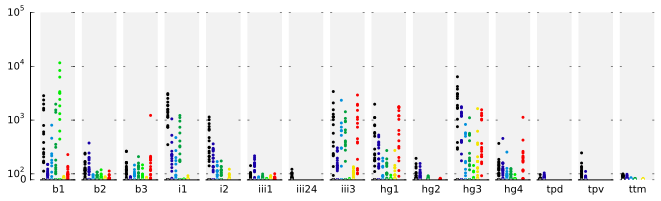

In [9]:
make_stats_summary(variable = 'auto')
plb.savefig('auto_corr_quant.pdf')

file missing


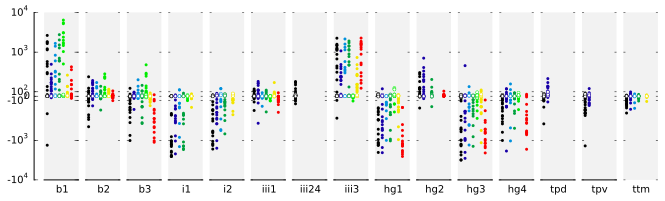

In [10]:
make_stats_summary(variable = 'amp')
plb.savefig('amp_corr_quant.pdf')

file missing


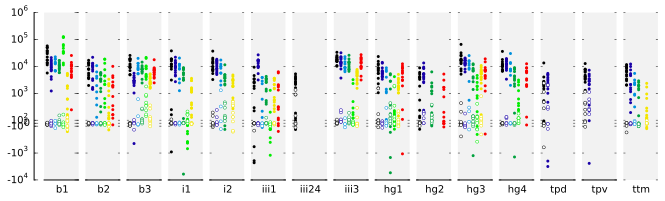

In [11]:
make_stats_summary(variable = 'freq')
plb.savefig('freq_corr_quant.pdf')

In [86]:
gmrlines = [gd.exp_swarms[key] for key in ['GMR22H05',
                                           'GMR10A12',
                                           'GMR74F03',
                                           'GMR75B06',
                                           'GMR29E05',
                                           'GMR31E10',
                                           'GMR39E01']]

ctrllines = [gd.ctrl_swarms[key] for key in ['GMR22H05_GFP',
                                            'GMR29E05_GFP',
                                            'GMR31E10_GFP']]

def make_stats_summary(variable = 'amp'):
    fig = plb.figure(figsize = (11,3))
    muscle_list = ['b1','b2','b3','i1','i2','iii1','iii24','iii3','hg1','hg2','hg3','hg4','tpd','tpv','ttm']
    cmap = plb.cm.spectral

    from matplotlib import gridspec
    gs = GridSpec(1,len(muscle_list))
    pans = [plb.subplot(gs[0,i],sharey = plb.gca(),sharex = plb.gca()) for i,m in enumerate(muscle_list)]
    cmax = len(gd.exp_swarms.values())

    for cidx,swarm in enumerate(gmrlines):
        #plb.subplot(7,1,cidx+1,sharey = plb.gca(),sharex = plb.gca())
        cval = float(cidx)/cmax
        offset = cidx*10000
        for fly in swarm.flies:
            try:
                pkldata = fly.get_pkl_data('nnls_fits_no_bk_dF_F_corr_data.cpkl')
                statdata = pkldata[variable]
                zero_idx = argwhere(pkldata['times']>0)[0]
                for i,mkey in enumerate(muscle_list):
                    plb.axes(pans[i])
                    try:
                        
                        c = cmap(cval)
                        c = (c[0],c[1],c[2],0.6)
                        
                        print(shape(statdata[mkey]))
                        #data_sorted = np.sort(data)
                        # calculate the proportional values of samples
                        #p = 1. * arange(len(data)) / (len(data) - 1)
                        #plot(data,p)
                        #plb.plot(np.cumsum(statdata[mkey][zero_idx][0]),color = cmap(cval))
                        #plb.plot((cval*1.2),statdata[mkey][zero_idx][0],
                        #        'o',color = cmap(cval), alpha = 0.5,ms = 3.0,
                        #        markeredgecolor  = 'none')
                        #plb.plot((i*2)+2,pkldata[mkey][zero_idx][0]+offset,
                        #         'o',color = plb.cm.jet(cval), alpha = 0.2,ms = 5.0,markeredgecolor  = 'none')
                    except KeyError:
                        pass#print mkey
                #kill_spines()
            except IOError:
                print 'file missing'

In [162]:
#### construct an interpolated matrix of cross correlation data
xcor = list()
flynums = list()
sig_types = list()
muscle_names = list()
swarm_names = list()

for swarm_name,swarm in gd.swarms.items():
    for fly in swarm.flies:
        try:
            pkldata = fly.get_pkl_data('nnls_fits_no_bk_dF_F_corr_data.cpkl')
            x = pkldata['times']
            for sig_type_key in ['amp', 'freq', 'auto']:
                for mkey in pkldata[sig_type_key].keys():
                    y = pkldata[sig_type_key][mkey]
                    from scipy import interpolate
                    tck = interpolate.splrep(x, y, s=0)
                    xnew = np.arange(-100,100,0.01)
                    ynew = interpolate.splev(xnew, tck, der=0)
                    xcor.append(ynew)
                    muscle_names.append(mkey)
                    sig_types.append(sig_type_key)
                    swarm_names.append(swarm_name)
                    flynums.append(fly.fly_num)
        except IOError:
            print 'no input file'

xcor = np.array(xcor)
flynums = np.array(flynums)
sig_types = np.array(sig_types)
muscle_names = np.array(muscle_names)
swarm_names = np.array(swarm_names)

no input file


In [199]:
import os
os.listdir(fly.fly_path)

['spectral_data_freq.cpkl',
 'resampled_sequences.hdf5',
 'nnls_fits.cpkl',
 'spectral_data.cpkl',
 'epoch_data.cpkl',
 'nnls_fits_no_bk.cpkl',
 'nnls_fits_no_bk_dF_F_corr_data.cpkl',
 'img_stats_df.cpkl',
 'nnls_fits_no_bk_dF_F.cpkl',
 'img_stats.cpkl',
 'basis_fits.cpkl',
 'nnls_fits_no_bk_dF_F_sigs.cpkl',
 'note.txt',
 'nnls_fits_no_bk_dF_F_sig_mtrx.cpkl',
 'fly_record.hdf5']

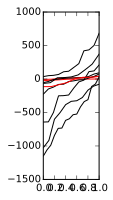

In [248]:
figure(figsize = (1,3))
for skey in gd.swarms.keys():
    selection = (sig_types == 'amp') & (muscle_names == 'b3') & (swarm_names == skey)
    data_sorted = np.sort(xcor[selection][:,xnew>0][:,0])
    p = 1. * arange(len(data_sorted)) / (len(data_sorted) - 1)
    if not('GFP' in skey):
        plot(p,data_sorted,color = 'k')
    else:
        plot(p,data_sorted,color = 'r')

In [51]:
def get_coher(img_ser,rwing_ser,basline_scalar,NFFT = 2**12):
    #from numpy import ones,zeros,hanning
    import numpy as np
    #from numpy import fft
    from scipy import signal
    from matplotlib import mlab
    
    df_f_ser = (img_ser-basline_scalar)/basline_scalar

    f,Pxx = signal.welch(df_f_ser,fs = 1/0.0450)
    f,Pyy = signal.welch(rwing_ser,fs = 1/0.0450)
    f,Pxy = mlab.csd(df_f_ser,rwing_ser,Fs = 1/0.0450)[::-1]
    f,Cxy = mlab.cohere(df_f_ser,rwing_ser,Fs = 1/0.0450)[::-1]
    return Pxx,Pyy,Pxy,Cxy,f

In [52]:
### set up the cluster
from IPython.parallel import Client
clients = Client(profile='nbserver') 
clients.block = True
print clients.ids
v = clients[:]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [56]:
def calc_spectral_stats(fly,sig_type = 'rwing'):
    print fly.fly_path
    import os
    if os.path.exists(fly.fly_path+ 'epoch_data.cpkl'):
        import h5py
        fly_record = h5py.File(fly.fly_path + 'fly_record.hdf5')
        imgs = np.array(fly_record['experiments'].values()[0]['tiff_data']['images'])
        import cPickle
        fi = open(fly.fly_path + 'epoch_data.cpkl')
        epch_data = cPickle.load(fi)
        fi.close()
        ### extract the signals of interest
        baseline_F = np.mean(imgs[epch_data['baseline_F'][0]:epch_data['baseline_F'][1],:,:].astype(float),axis = 0)
        sigs = fly_record['experiments'].values()[0]['tiff_data']['axon_framebase']
        wfreq = np.array(sigs['wb_frequency'])
        rwing = np.array(sigs['Ph1'])
        idx = (np.array(sigs['StimCond']) < 0) & (wfreq > 100)

        ### create a mapable data set
        X,Y = np.meshgrid(*[np.arange(x) for x in np.shape(imgs[0])])
        pairs = zip(X.ravel(),Y.ravel())
        tl = np.shape(imgs)[0]
        PX = [np.array(imgs[idx[0:tl],x,y]) for x,y in pairs]
        
        if sig_type == 'rwing':
            WA = [np.array(rwing[idx[0:tl]]) for x,y in pairs]
        else:
            WA = [np.array(wfreq[idx[0:tl]]) for x,y in pairs]
            
        BA = [baseline_F[x,y] for x,y in pairs]
        NFFT = [2**8 for x,y in pairs]
        ### map the data
        spectral_data = v.map(get_coher,PX,WA,BA,NFFT)
        sdata = np.array(spectral_data)
        save_dict = dict()
        ### extract the data
        save_dict['df_f_psd'] = transpose(sdata[:,0,:].reshape(174,130,-1),(2,1,0))
        save_dict['wing_psd'] = transpose(sdata[:,1,:].reshape(174,130,-1),(2,1,0))
        save_dict['df_f_wing_csd'] = transpose(sdata[:,2,:].reshape(174,130,-1),(2,1,0))
        save_dict['df_f_wing_coherence'] = transpose(sdata[:,3,:].reshape(174,130,-1).astype(float),(2,1,0))
        save_dict['spectral_frequencies'] = transpose(sdata[:,4,:].reshape(174,130,-1).astype(float),(2,1,0))
        
        print save_dict['spectral_frequencies'][0][0][0],save_dict['spectral_frequencies'][-1][0][0]
        ### save the data
        if sig_type == 'rwing':
            fl = open(fly.fly_path + 'spectral_data.cpkl','wb')
        else:
            fl = open(fly.fly_path + 'spectral_data_freq.cpkl','wb')
            
        cPickle.dump(save_dict,fl)
        fl.close()
    else:
        print 'no path'

In [57]:
for gmrline in gmrlines:
    for fly in gmrline.flies:
        try:
            calc_spectral_stats(fly,sig_type = 'freq')
        except error as er:
            print er
#for fly in gmrlines[5].flies:
#    calc_spectral_stats(fly)

/media/FlyDataC/FlyDB/Fly0308/
0.0 11.1111111111
/media/FlyDataC/FlyDB/Fly0309/
0.0 11.1111111111
/media/FlyDataC/FlyDB/Fly0310/
0.0 11.1111111111
/media/FlyDataC/FlyDB/Fly0311/
0.0 11.1111111111
/media/FlyDataC/FlyDB/Fly0312/
0.0 11.1111111111
/media/FlyDataC/FlyDB/Fly0313/
no path
/media/FlyDataC/FlyDB/Fly0314/
0.0 11.1111111111
/media/FlyDataC/FlyDB/Fly0315/
0.0 11.1111111111
/media/FlyDataC/FlyDB/Fly0316/
0.0 11.1111111111
/media/FlyDataC/FlyDB/Fly0317/
0.0 11.1111111111
/media/FlyDataC/FlyDB/Fly0327/
0.0 11.1111111111
/media/FlyDataC/FlyDB/Fly0328/
0.0 11.1111111111
/media/FlyDataC/FlyDB/Fly0387/
0.0 11.1111111111
/media/FlyDataC/FlyDB/Fly0388/
0.0 11.1111111111
/media/FlyDataC/FlyDB/Fly0389/
0.0 11.1111111111
/media/FlyDataC/FlyDB/Fly0399/
0.0 11.1111111111
/media/FlyDataC/FlyDB/Fly0400/
0.0 11.1111111111
/media/FlyDataC/FlyDB/Fly0401/
0.0 11.1111111111
/media/FlyDataC/FlyDB/Fly0408/
0.0 11.1111111111
/media/FlyDataC/FlyDB/Fly0409/
0.0 11.1111111111
/media/FlyDataC/FlyDB/Fly0410/

/home/psilentp/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
/home/psilentp/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:41: ComplexWarning: Casting complex values to real discards the imaginary part


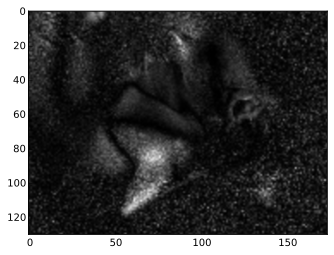

In [413]:
imshow(data['fre'][16],cmap = cm.gray)

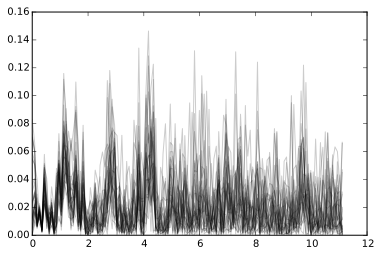

In [338]:
for i in range(30):
    Pxx,Pyy,Pxy,Cxy,f = get_coher(PX[i],WA[i],BA[i],NFFT[i])
    plot(f,Cxy,alpha = 0.2,color = 'k')

In [ ]:
    def detrend_mean(x):
        return x - np.mean(x)

    def detrend_none(x):
        return x

    def detrend_linear(x):
        """Remove the best fit line from x"""
        # I'm going to regress x "n xx=rarwingnge(len(x)) and return
        # x - (b*xx+a)
        xx = np.arange(len(x), dtype = x.dtype)
        X = np.transpose(np.array([xx]+[x]))
        C = np.cov(X)
        b = C[0,1]/C[0,0]
        a = np.mean(x) - b*np.mean(xx)
        return x-(b*xx+a)

    def window_hanning(x):
        return np.hanning(len(x))*x

    def csd(x, y, NFFT=256, Fs=2, detrend=detrend_none,
            window=window_hanning, noverlap=0):
        """
        The cross spectral density Pxy by Welches average periodogram
        method.  The vectors x and y are divided into NFFT length
        segments.  Each segment is detrended by function detrend and
        windowed by function window.  noverlap gives the length of the
        overlap between segments.  The product of the direct FFTs of x and
        y are averaged over each segment to compute Pxy, with a scaling to
        correct for power loss due to windowing.  Fs is the sampling
        frequency.

        NFFT must be a power of 2

        Refs:
          Bendat & Piersol -- Random Data: Analysis and Measurement
            Procedures, John Wiley & Sons (1986)

        """

        if NFFT % 2:
            raise ValueError, 'NFFT must be a power of 2'

        # zero pad x and y up to NFFT if they are shorter than NFFT
        if len(x)<NFFT:
            n = len(x)
            x = resize(x, (NFFT,))
            x[n:] = 0
        if len(y)<NFFT:
            n = len(y)
            y = resize(y, (NFFT,))
            y[n:] = 0

        # for real x, ignore the negative frequencies
        #if x.typecode()==Complex: numFreqs = NFFT
        #else: 
        numFreqs = NFFT//2+1

        windowVals = window(np.ones((NFFT,),x.dtype))
        step = NFFT-noverlap
        ind = range(0,len(x)-NFFT+1,step)
        n = len(ind)
        Pxy = np.zeros((numFreqs,n), np.complex)

        # do the ffts of the slices
        for i in range(n):
            thisX = x[ind[i]:ind[i]+NFFT]
            thisX = windowVals*detrend(thisX)
            thisY = y[ind[i]:ind[i]+NFFT]
            thisY = windowVals*detrend(thisY)
            fx = fft.fft(thisX)
            fy = fft.fft(thisY)
            Pxy[:,i] = fy[:numFreqs]*np.conjugate(fx[:numFreqs])

        # Scale the spectrum by the norm of the window to compensate for
        # windowing loss; see Bendat & Piersol Sec 11.5.2
        if n>1: Pxy = np.mean(Pxy,1)
        Pxy = np.divide(Pxy, np.linalg.norm(windowVals)**2)
        freqs = Fs/NFFT*np.arange(0,numFreqs)
        return Pxy, freqs


    def psd(x, NFFT=256, Fs=2, detrend=detrend_none,
            window=window_hanning, noverlap=0):
        """
        The power spectral density by Welches average periodogram method.
        The vector x is divided into NFFT length segments.  Each segment
        is detrended by function detrend and windowed by function window.
        noperlap gives the length of the overlap between segments.  The
        absolute(fft(segment))**2 of each segment are averaged to compute Pxx,
        with a scaling to correct for power loss due to windowing.  Fs is
        the sampling frequency.

        -- NFFT must be a power of 2
        -- detrend and window are functions, unlike in matlab where they are
           vectors.
        -- if length x < NFFT, it will be zero padded to NFFT


        Refs:
          Bendat & Piersol -- Random Data: Analysis and Measurement
            Procedures, John Wiley & Sons (1986)

        """

        if NFFT % 2:
            raise ValueError, 'NFFT must be a power of 2'

        # zero pad x up to NFFT if it is shorter than NFFT
        if len(x)<NFFT:
            n = len(x)
            x = resize(x, (NFFT,))
            x[n:] = 0


        # for real x, ignore the negative frequencies
        #if x.typecode()==Complex: numFreqs = NFFT
        #else: 
        numFreqs = NFFT//2+1

        windowVals = window(np.ones((NFFT,),dtype = x.dtype))
        step = NFFT-noverlap
        ind = range(0,len(x)-NFFT+1,step)
        n = len(ind)
        Pxx = np.zeros((numFreqs,n), np.float)

        # do the ffts of the slices
        for i in range(n):
            thisX = x[ind[i]:ind[i]+NFFT]
            thisX = windowVals*detrend(thisX)
            fx = np.abs(fft.fft(thisX))**2
            Pxx[:,i] = fx[:numFreqs]

        # Scale the spectrum by the norm of the window to compensate for
        # windowing loss; see Bendat & Piersol Sec 11.5.2
        if n>1: Pxx = np.mean(Pxx,1)
        Pxx = np.divide(Pxx, np.linalg.norm(windowVals)**2)
        freqs = Fs/NFFT*np.arange(0,numFreqs)
        return Pxx, freqs

In [ ]:
    #Pxx,f = psd(df_f_ser,Fs = 1/0.0450,detrend = detrend_linear,noverlap = 50,NFFT=NFFT)
    #Pyy,f = psd(rwing_ser,Fs = 1/0.0450,detrend = detrend_linear,noverlap = 50,NFFT=NFFT)
    #Pxy,f = csd(df_f_ser, rwing_ser,Fs = 1/0.0450,detrend = detrend_linear,noverlap = 50,NFFT=NFFT)
    #Cxy = np.abs(Pxy)**2/ Pxx*Pyy